<a href="https://colab.research.google.com/github/pmandros/tsp_gnn_metalayer_solver/blob/main/TSP_GNN_solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Traveling Salesman Problem (TSP) is a classic optimization problem in the field of operations research and computer science. It poses a straightforward yet computationally challenging question: given a list of cities and the distances between each pair of them, what is the shortest possible route that visits each city exactly once and returns to the origin city? Despite its apparent simplicity, the TSP is known for its combinatorial explosion of possible routes as the number of cities increases, making it a quintessential NP-hard problem.

Traditional methods for solving the TSP, such as brute-force search, dynamic programming, and heuristic algorithms, often struggle with scalability and efficiency as the problem size grows. This is where modern approaches, particularly those involving machine learning and neural networks, can offer significant advantages. Machine learning techniques, especially neural networks, have shown promise in addressing the TSP by leveraging their ability to learn and generalize patterns from data. Neural networks could be possibly trained to predict good approximations of optimal routes, significantly reducing computational time compared to traditional exhaustive search methods. Of course, no guarantees about the quality of the solution can be made (at least as of now).

This notebook is a small demonstration of how graph neural networks can be used to solve TSP. In particular, I used the Metalayer technique from https://arxiv.org/abs/1806.01261 implemented by torch-geometric, which is a generalization/abstraction of graph neural networks with traditional fully connected neural neworks.  

I was unaware of the work from Joshi et al. https://arxiv.org/abs/2006.07054 while doing this, but I am very happy to have reached similar conclusions indepedently (and learning some of the terminology). I highly recommend reading this paper to learn more.

In [1]:
# #first install the necessary libraries
# !pip install scipy
# # !pip install --upgrade numpy


In [1]:
#this can take a long time. Adjust accordingly for
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)


!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

# !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=507270 sha256=80d29dfbed81d9ca79a88e3a445a44aa55d4fc07accdc8aa8e21213232e07ddd
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
Successfully built torch-scatter
Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl size=1092570 sha256=ed3b9a1a6a56372c05b7e3585c90d52b023967bd9d09e3246a8c5d90c3162f37
  Stored in directory: /root/.cache/pip/wheels/c9/dd/0f/a6a16f9f3b0236733d257b4b4ea91b548b984a341ed3b8f38c
Successfully built to

In [3]:
#a library that optimally solves the travelling salesman problem to be used to generate training and test datasets

!pip install 'pyconcorde @ git+https://github.com/jvkersch/pyconcorde'


  Cloning https://github.com/jvkersch/pyconcorde to /tmp/pip-install-ibhqh3b4/pyconcorde_970c20298a244371b79691550a01751d
  Running command git clone --filter=blob:none --quiet https://github.com/jvkersch/pyconcorde /tmp/pip-install-ibhqh3b4/pyconcorde_970c20298a244371b79691550a01751d
  Resolved https://github.com/jvkersch/pyconcorde to commit f75601d2534de2101902cefdc250f2f98f3f8a2c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 54.9 MB/s eta 0:00:00
  Created wheel for pyconcorde: filename=pyconcorde-0.1.0-cp310-cp310-linux_x86_64.whl size=2576693 sha256=414c6eb636f8f3fafaf52e1cbe8624109734897e5901ca648a25a691bc57ef59
  Stored in directory: /tmp/pip-ephem-wheel-cache-ry77ruwl/wheels/be/9f/eb/e4f95e06e62f057a045679e4940e536d1b251d1ab4859c6dcc
Successfully built pyconcorde
  Attempting uninstall: tabulate
    Found existing installation: tabulat

In [4]:
import numpy as np

import pandas as pd
from typing import Optional, Tuple


import warnings
warnings.filterwarnings("ignore")


In [5]:
#functions that generate tsp instances

from concorde.tsp import TSPSolver

def generate_tsp_data(num_nodes, num_datasets, check_correct=False):
    """
    Generate data for the Traveling Salesman Problem (TSP) for multiple datasets.

    Parameters:
        num_nodes (int): The number of nodes (cities) in each dataset.
        num_datasets (int): The number of datasets to generate.
        check_correct (bool, optional): If True, verify the correctness of the TSP solution. Defaults to False.

    Returns:
        tuple: A tuple containing the following:
            - node_coords (list): A list of arrays representing the coordinates of nodes for each dataset.
            - distance_matrices (list): A list of distance matrices for each dataset.
            - solutions (list): A list of adjacency matrices representing TSP solutions for each dataset.
            - distances (list): A list of distances for each dataset.
            - knn_adj_matrices (list): A list of k-nearest neighbors adjacency matrices for each dataset.
    """
    node_coords = []  # List to store the coordinates of nodes for each dataset
    distance_matrices = []  # List to store distance matrices for each dataset
    solution_distances = []  # List to store distances for each dataset
    solution_paths = []  # List to store TSP solutions for each dataset
    solution_adjacencies = []

    # Generate data for each dataset
    for _ in range(num_datasets):
        # Generate random 2D points in the unit square
        points = 100.0*np.random.rand(num_nodes, 2)

        # Compute the distance matrix based on Euclidean distance between points
        # distance_matrix = np.sqrt(((points[:, 0] - points[:, 1].T) ** 2).sum())
        n = points.shape[0]
        distance_matrix = np.sqrt(((points[:, np.newaxis] - points) ** 2).sum(axis=2))

        solver = TSPSolver.from_data(points[:,0],points[:,1] ,norm='EUC_2D')
        solution = solver.solve()
        solution_path = solution.tour
        solution_value = solution.optimal_value
        # Convert TSP solution to adjacency matrix
        if check_correct:
            solution_adjacency = tsp_solution_to_adjacency(solution_path, solution_value, distance_matrix)
        else:
            solution_adjacency = tsp_solution_to_adjacency(solution_path)


        # Store node coordinates and distance matrix
        node_coords.append(points)
        distance_matrices.append(distance_matrix)
        solution_adjacencies.append(solution_adjacency)
        solution_distances.append(solution_value)
        solution_paths.append(solution_path)

    return node_coords, distance_matrices, solution_paths, solution_adjacencies, solution_distances


def tsp_solution_to_adjacency(permutation, distance=None, distance_matrix=None):
    """
    Convert a permutation sequence into an adjacency matrix.

    Args:
        permutation (list or array-like): Permutation sequence representing the order of nodes.
        distance (float, optional): Expected distance value. Defaults to None.
        distance_matrix (array-like, optional): Distance matrix representing distances between nodes.
                                                Defaults to None.

    Returns:
        numpy.ndarray: Adjacency matrix representing the connections between nodes.

    Raises:
        AssertionError: If distance is provided and distance_matrix is not None, the sum of distances
                        calculated from the adjacency matrix does not match the provided distance value
                        within a tolerance.

    Notes:
        - The permutation sequence represents the TSP (appox.) solution.
        - The resulting adjacency matrix represents the connections between nodes based on the given
          permutation sequence. Each row and column correspond to a node, and the value at position (i, j)
          in the matrix is 1 if there is a connection from node i to node j, and 0 otherwise.
        - If `distance` and `distance_matrix` are provided, the function checks if the sum of distances
          calculated from the adjacency matrix matches the provided distance value within a tolerance.
    """
    size = len(permutation)
    to_return = np.zeros((size, size))
    for i in range(size - 1):
        curr = permutation[i]
        next_ = permutation[i + 1]
        to_return[curr, next_] = 1
    to_return[next_, 0] = 1

    if distance is not None:
        if distance_matrix is not None:
            masked_values = to_return * distance_matrix
            # Sum along the appropriate axis
            sum_values = np.sum(masked_values, axis=(0, 1))
            assert np.allclose(sum_values, distance, rtol=0.5, atol=0)

    return to_return


The main metric we are interested in for assessing the quality of the solution is the relative gap between the predicted distance versus the actual solution distance. For example, a relative gap close to 0 implies the predicted solution is nearly optimal, while a gap of 0.5 implies the predicted distance is twice as big as the optimal.

Another one we use (just for fun) is the path disagreement, that is, how many nodes are different between solution path and predicted path.

In [6]:
#functions that are useful for assessing quality of solutions

import torch
import numpy as np

def find_greedy_max_neighbor_traversal(weighted_matrix):
    """
    Find the order of traversal starting from the first node as the root
    by greedily selecting the most probable neighbor that is not in the path yet.

    Parameters:
        weighted_matrix (torch.Tensor): Weighted adjacency matrix representing the graph.

    Returns:
        Tensor: Order of traversal starting from the first node.
    """
    # Start traversal from the first node (index 0)
    path = [0]  # Start with the first node
    num_nodes = weighted_matrix.size(0)
    current_node = 0

    # Traverse through the nodes until reaching the last node
    while len(path) < num_nodes:
        # Find the next node (neighbor) with the maximum weight
        max_weight = -float('inf')
        next_node = -1
        for neighbor, weight in enumerate(weighted_matrix[current_node]):
            if neighbor not in path and weight > max_weight:
                max_weight = weight
                next_node = neighbor
        if next_node == -1:
            break  # No valid neighbor found, exit the loop
        else:
            current_node = next_node
            path.append(current_node)

    return torch.Tensor(path)

def count_disagreements(tensor1, tensor2):
    """
    Count the number of positions where two tensors of the same length disagree.

    Parameters:
        tensor1 (torch.Tensor): First tensor.
        tensor2 (torch.Tensor): Second tensor.

    Returns:
        int: Number of positions where the tensors disagree.
    """

    # Ensure both tensors have the same length
    assert tensor1.size() == tensor2.size(), "Tensors must have the same length"

    # Count number of disagreements
    num_disagreements_one_way = (tensor1[1:] != tensor2[1:]).sum().item()
    num_disagreements_other_way = (tensor1[1:] != torch.flip(tensor2[1:], [0])).sum().item()


    return min(num_disagreements_one_way,num_disagreements_other_way)


def mean_per_batch_optimality_metrics(heatmap_pred, heatmap_true, num_graphs, num_nodes, edge_weights, true_distance):
    l1_path_distances = 0
    rel_l1_optimality_gaps = 0
    for i in range(num_graphs):
        solution_path = find_greedy_max_neighbor_traversal(heatmap_pred[i,:,:])
        l1_path_distances += count_disagreements(solution_path,heatmap_true[i,:])

        pred_distance  = sum([edge_weights[i, int(solution_path[j].item()), int(solution_path[j+1].item()) ] for j in range(num_nodes-1)] + [edge_weights[i, int(solution_path[-1].item()),0 ] ])
        rel_l1_optimality_gaps +=  (pred_distance - true_distance[i])/ true_distance[i]
    return l1_path_distances/num_graphs , rel_l1_optimality_gaps/num_graphs

In [7]:
#Creating the data, e.g., in this example, we create 1000 graphs with 10 nodes, 1000 with 15, etc.
#We create graphs with varying number of nodes such that the neural network can learn to generalize.
#Ideally we want many graphs and with many different number of nodes, but that can create computational problems if we lack the resources
#or it the GNN we consider have many parameters.
#Also, the bigger the graph, the more time concorde will need for solving (NP-hard problem)

from torch_geometric.utils import to_undirected,add_self_loops
from torch_geometric.data import Data
import itertools


data_list = []

num_datasets = 1000

for num_nodes in [10,15,20,25,30]:
  node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = generate_tsp_data(num_nodes = num_nodes,  num_datasets = num_datasets, check_correct=True)

  num_pos = num_nodes
  num_neg = num_nodes**2-num_nodes



  weight_pos_class = (num_neg/num_pos)

  edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
  for i in range(len(node_coords)):
      edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

      x = torch.tensor(node_coords[i]).float()
      y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)


      data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
      data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
      data.true_path = torch.Tensor(solution_paths[i])
      data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
      data.num_nodes = num_nodes
      data.pos_class_weight = weight_pos_class
      data_list.append(data)



In [8]:
#split the data to train, test, val

from torch_geometric.loader import DataLoader
import random

total_length = len(data_list)

# Calculate lengths of each part based on percentages
train_length = int(total_length * 0.7)
val_length = int(total_length * 0.1)

shuffled_list = random.sample(data_list, len(data_list))

# train, validate, test = np.split(data_list, [int(len(data_list)*0.7), int(len(data_list)*0.8)])
train_list = shuffled_list[:train_length]
val_list = shuffled_list[train_length:train_length + val_length]
test_list = shuffled_list[train_length + val_length:]




In [9]:
#to train the GNN with graphs of different sizes, we have to create batches with each batch having graphs of the same size.
#(Not sure there is another way for this)

max_batch_size = 2048  # Maximum batch size
train_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(train_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not train_batched_data or train_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        train_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = train_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            train_batched_data.append([dataset])

print(len(train_batched_data))


37


In [10]:
val_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(val_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not val_batched_data or val_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        val_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = val_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            val_batched_data.append([dataset])



In [11]:
test_batched_data = []

# Sort the datasets based on the number of nodes
sorted_datasets = sorted(test_list, key=lambda x: x.num_nodes)

for dataset in sorted_datasets:
    if not test_batched_data or test_batched_data[-1][-1].num_nodes != dataset.num_nodes:
        # If the current batch is empty or the last dataset in the current batch has a different number of nodes,
        # start a new batch with the current dataset
        test_batched_data.append([dataset])
    else:
        # If adding the current dataset to the last batch doesn't exceed the maximum batch size,
        # add it to the last batch
        current_batch = test_batched_data[-1]
        if sum(data.num_nodes for data in current_batch) + dataset.num_nodes <= max_batch_size:
            current_batch.append(dataset)
        else:
            # Otherwise, start a new batch with the current dataset
            test_batched_data.append([dataset])



In [12]:
#create the data loaders

from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_batched_data, batch_size=None, shuffle=True)
val_loader = DataLoader(val_batched_data, batch_size=None, shuffle=True)
test_loader = DataLoader(test_batched_data, batch_size=None, shuffle=True)




In [ ]:
# #save data

# torch.save(train_loader, 'TSP_1020304050_exact_train.pth')
# torch.save(test_loader, 'TSP_1020304050_exact_test.pth')
# torch.save(val_loader, 'TSP_1020304050_exact_val.pth')

In [ ]:
#load data


# train_loader = torch.load('/content/TSP_58101215/25000_512batch_exact_train.pth')
# test_loader = torch.load( '/content/TSP_58101215/25000_512batch_exact_test.pth')
# val_loader = torch.load( '/content/TSP_58101215/25000_512batch_exact_val.pth')


The Graph Neural Network we consider is based on the Metalayer, which is an generalization of graph neural networks using regular neural networks as opposed to graph layers. In summary, there exists a neural network model for each graph entity, namely nodes, edges, and global. In each step, embeddings are aggregated and concatenated to other entities. We additionally use batch normalization and residual connections. The decoder is a simple inner product (although more options are implemented). Note that in our case we are not using information.

A novelty in our approach is the following. Normally, practical graphs are not fully connected which allows information about nodes and edges to be aggregated from neighboring nodes and edges. In our case, we are using a fully connected graph where edge weights are the distances between the nodes in the TSP (a problem relaxation would be to connect each node only with its closest k neighbors). This means that we have to essentially aggregate over all nodes which can be problematic, e.g., information is being heavily smoothed. For this reason, we perform a weighted aggregation using the Euclidean distances between nodes.

We have two types of initial features. For nodes, we use the 2D coordinates. For edges, we use the edge weights. Both are then mapped to embeddings of fixed hidden size, e.g., 128.

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch.nn import Sequential as Seq, Linear as Lin, ReLU, BatchNorm1d
from torch_geometric.utils import scatter
from torch_geometric.nn import MetaLayer
from torch import Tensor

from typing import Optional, Tuple


class EdgeModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 3 * hidden_dim )

        self.edge_mlp = Seq(BatchNorm1d(in_channels),
                            ReLU(),
                            Lin(in_channels, hidden_dim,bias=False))

    def forward(self, src, dst, edge_attr, edge_weight, u,  batch):
        # src, dst: [E, F_x], where E is the number of edges.
        # edge_attr: [E, F_e]
        # edge_weight: [E, 1]
        # u: [B, F_u], where B is the number of graphs.
        # batch: [E] with max entry B - 1.

        # out = torch.cat([src, dst, edge_attr, u[batch]], 1)
        out = torch.cat([src, edge_attr,dst], 1)

        return self.edge_mlp(out) + edge_attr

class NodeModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 2 * hidden_dim)

        self.node_mlp_1 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim)
                              )
        self.node_mlp_2 = Seq(BatchNorm1d(in_channels),
                              ReLU(),
                              Lin(in_channels, hidden_dim))

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # edge_weight: [E, 1]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index


        out = torch.cat([x[row], edge_attr], dim=1)
        out = self.node_mlp_1(out)
        out = scatter(edge_weight.to(device)*out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')
        out = torch.cat([x, out], dim=1)
        # out = torch.cat([x, out, u[batch]], dim=1)


        return self.node_mlp_2(out) + x

class GlobalModel(torch.nn.Module):
    def __init__(self,hidden_dim):
        super().__init__()
        in_channels = ( 2 * hidden_dim)

        self.global_mlp = Seq(BatchNorm1d(in_channels),
                            ReLU(),
                            Lin(in_channels, hidden_dim,bias=False))

    def forward(self, x, edge_index, edge_attr, u, batch):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        out = torch.cat([
            u,
            scatter(x, batch, dim=0, reduce='mean'),
        ], dim=1)
        return self.global_mlp(out) + u

class MetaLayer(torch.nn.Module):
    def __init__(self,edge_model,node_model,global_model):
        super(MetaLayer, self).__init__()
        self.edge_model = edge_model
        self.node_model = node_model
        self.global_model = global_model

    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
        edge_attr: Optional[Tensor] = None,
        edge_weight: Optional[Tensor] = None,
        u: Optional[Tensor] = None,
        batch: Optional[Tensor] = None,
    ) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
        r"""Forward pass.

        Args:
            x (torch.Tensor): The node features.
            edge_index (torch.Tensor): The edge indices.
            edge_attr (torch.Tensor, optional): The edge features.
                (default: :obj:`None`)
            edge_weight (torch.Tensor, optional): The edge weight (scalar vector).
                (default: :obj:`None`)
            u (torch.Tensor, optional): The global graph features.
                (default: :obj:`None`)
            batch (torch.Tensor, optional): The batch vector
                :math:`\mathbf{b} \in {\{ 0, \ldots, B-1\}}^N`, which assigns
                each node to a specific graph. (default: :obj:`None`)
        """
        row = edge_index[0]
        col = edge_index[1]

        if self.edge_model is not None:
            edge_attr = self.edge_model(x[row], x[col], edge_attr, edge_weight, u,
                                        batch if batch is None else batch[row])

        if self.node_model is not None:
            x = self.node_model(x, edge_index, edge_attr, edge_weight, u, batch)

        if self.global_model is not None:
            u = self.global_model(x, edge_index, edge_attr, u, batch)

        return x, edge_attr, u


class METALAYER_TSP_SOLVER(torch.nn.Module):
    def __init__(self,node_input_dim, edge_input_dim, hidden_dim, decoder ='edge_emb', use_edge_weight=True):
        super(METALAYER_TSP_SOLVER, self).__init__()
        self.lin0_edge = Seq(Lin(edge_input_dim, hidden_dim,bias=False),BatchNorm1d(hidden_dim),ReLU())
        self.lin0_node = Seq(Lin(node_input_dim, hidden_dim,bias=False),BatchNorm1d(hidden_dim),ReLU())

        self.edge_lin1 = Lin((hidden_dim), hidden_dim)
        self.node_lin1 = Lin((hidden_dim*2), hidden_dim)
        self.nodes_edge_lin1 = Lin((hidden_dim*3), hidden_dim)


        self.lin2 = Lin(hidden_dim, 1)

        self.decoder = decoder

        self.use_edge_weight=use_edge_weight

        self.metalayer = MetaLayer(EdgeModel(hidden_dim), NodeModel(hidden_dim),  None)
        self.metalayer2 = MetaLayer(EdgeModel(hidden_dim), NodeModel(hidden_dim),  None)

    def forward(self, x, edge_index, edge_attr, edge_weight, u, batch):
        edge_attr = self.lin0_edge(edge_attr)
        x = self.lin0_node(x)

        if self.use_edge_weight==True and edge_weight is not None:
            edge_weight = torch.ones(edge_attr.shape[0],1)

        x, edge_attr, u = self.metalayer(x, edge_index, edge_attr, edge_weight, None, batch)
        x, edge_attr, u = self.metalayer2(x, edge_index, edge_attr, edge_weight, None, batch)

        if  self.decoder=='edge_emb':
            out = self.edge_lin1(edge_attr)
        elif self.decoder=='nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], x[col]], dim=-1)
            out = self.node_lin1(z)
        elif self.decoder=='edge_nodes_emb':
            row, col = edge_index
            z = torch.cat([x[row], edge_attr, x[col]], dim=-1)
            out = self.nodes_edge_lin1(z)
        elif self.decoder=='node_inner_product':
            row, col = edge_index
            out = (x[row]*x[col]).sum(dim=1).unsqueeze(1)
        elif self.decoder=='cond_node_inner_product':
            row, col = edge_index
            out = x[row]
            out = scatter(edge_weight*out, col, dim=0, dim_size=x.size(0),
                      reduce='mean')

            out = torch.cat([x, out], dim=-1)

            out = (out[row]*out[col]).sum(dim=1).unsqueeze(1)
        else:
            raise ValueError('Possible decoders are edge_emb, nodes_emb, edge_nodes_emb, node_inner_product, and cond_node_inner_product')

        if "inner_product" not in self.decoder:
            out = self.lin2(out)

        return out


We initialize the solver. We need to be careful with the optimization. We are using graphs of different sizes, with each batch having graphs of same size. We use the binary cross entropy loss and weight each batch with the ratio of solution edges compared to total edges.

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


edge_input_dim = 1
node_input_dim = 2
hidden_dim=128

use_edge_weight = True


num_epochs=16


model = METALAYER_TSP_SOLVER(node_input_dim,edge_input_dim, hidden_dim, decoder="node_inner_product",use_edge_weight=use_edge_weight)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.00005)

criterion = torch.nn.BCEWithLogitsLoss(reduction='none')

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {pytorch_total_params}')


Number of parameters: 333185


In [17]:
def train(train_loader):
    model.train()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for train_data in train_loader:  # Iterate in batches over the training dataset.
        train_data.x = train_data.x.to(device)
        train_data.edge_index= train_data.edge_index.to(device)
        train_data.edge_attr = train_data.edge_attr.to(device)
        train_data.edge_weight = train_data.edge_weight.to(device)
        train_data.batch = train_data.batch.to(device)
        global_model_x=train_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(train_data.x, train_data.edge_index,train_data.edge_attr, train_data.edge_weight, None, train_data.batch)  # Perform a single forward pass.
        train_loss = criterion(out, train_data.y.to(device))  # Compute the loss.

        batch_weights = torch.ones(train_loss.shape)

        mask = train_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= train_data.pos_class_weight[0]

        train_loss = train_loss * batch_weights.to(device)
        train_loss = train_loss.sum() / batch_weights.sum()

        train_loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.

        for_view = int(train_data.num_nodes/train_data.num_graphs)
        batch_out_heat_map=out.view((train_data.num_graphs, for_view,for_view))
        batch_truth_heat_map=train_data.true_path.view((train_data.num_graphs, for_view))
        batch_edge_weights=train_data.edge_weight.view((train_data.num_graphs, for_view, for_view))
        batch_true_distancess =  train_data.true_distance.view((train_data.num_graphs))

        l1_path_distance, l1_gap = mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, train_data.num_graphs,  for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap

    return train_loss, l1_path_distances/len(train_loader), l1_optimality_gaps/len(train_loader)

def test(loader):
    model.eval()
    l1_path_distances = 0
    l1_optimality_gaps = 0

    for test_data in loader:  # Iterate in batches over the training dataset.
        test_data.x = test_data.x.to(device)
        test_data.edge_index= test_data.edge_index.to(device)
        test_data.edge_attr = test_data.edge_attr.to(device)
        test_data.edge_weight = test_data.edge_weight.to(device)
        test_data.batch = test_data.batch.to(device)
        global_model_x=test_data.pos_class_weight.unsqueeze(1).to(device)
        out = model(test_data.x, test_data.edge_index,test_data.edge_attr, test_data.edge_weight, test_data.pos_class_weight.unsqueeze(1), test_data.batch)  # Perform a single forward pass.
        test_loss = criterion(out, test_data.y.to(device))  # Compute the loss.


        batch_weights = torch.ones(test_loss.shape).to(device)

        mask = test_data.y.bool()  # Add a dimension to match the shape of ones_tensor
        batch_weights[mask.squeeze()] *= test_data.pos_class_weight[0]

        test_loss = test_loss * batch_weights
        test_loss = test_loss.sum() / batch_weights.sum()


        for_view = int(test_data.num_nodes/test_data.num_graphs)

        batch_out_heat_map=out.view((test_data.num_graphs, for_view, for_view))
        batch_truth_heat_map=test_data.true_path.view((test_data.num_graphs, for_view))
        batch_edge_weights=test_data.edge_weight.view((test_data.num_graphs, for_view, for_view))
        batch_true_distancess =  test_data.true_distance.view((test_data.num_graphs))

        l1_path_distance, l1_gap = mean_per_batch_optimality_metrics(batch_out_heat_map, batch_truth_heat_map, test_data.num_graphs, for_view, batch_edge_weights,batch_true_distancess)
        l1_path_distances += l1_path_distance
        l1_optimality_gaps += l1_gap


    return test_loss, l1_path_distances/len(loader), l1_optimality_gaps/len(loader)

train_losses = []
test_losses = []
val_losses = []

train_l1_opt_gaps = []
test_l1_opt_gaps = []
val_l1_opt_gaps = []

for epoch in range(0, num_epochs+1):
    train_loss, train_l1_path_dist, train_opt_gap = train(train_loader)
    #we use the validation part also for training
    train_loss, train_l1_path_dist, train_opt_gap = train(val_loader)


    val_loss, val_l1_path_dist, val_opt_gap  = test(val_loader)

    test_loss, test_l1_path_dist, test_opt_gap  = test(test_loader)

    if epoch%5 ==0:
        print(f'Epoch: {(epoch+1):03d}')
        print(f'\t Train loss: {train_loss:.4f} L1 path dist: {train_l1_path_dist:.4f} opt. gap  {train_opt_gap:.4f}')
        print(f'\t Val loss: {val_loss:.4f} L1 path dist: {val_l1_path_dist:.4f} opt. gap  {val_opt_gap:.4f}')
        print(f'\t Test loss: {test_loss:.4f} L1 path dist: {test_l1_path_dist:.4f} opt. gap  {test_opt_gap:.4f}')
        print()

    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    val_losses.append(val_loss.item())

    train_l1_opt_gaps.append(train_opt_gap.item())
    test_l1_opt_gaps.append(test_opt_gap.item())
    val_l1_opt_gaps.append(val_opt_gap.item())


Epoch: 001
	 Train loss: 0.5276 L1 path dist: 15.4192 L1 dist. gap  0.1533
	 Val loss: 0.5805 L1 path dist: 15.2784 L1 dist. gap  0.1400
	 Test loss: 0.6502 L1 path dist: 16.0424 L1 dist. gap  0.1461

Epoch: 006
	 Train loss: 0.4673 L1 path dist: 14.3396 L1 dist. gap  0.1065
	 Val loss: 0.4956 L1 path dist: 14.3492 L1 dist. gap  0.1085
	 Test loss: 0.4962 L1 path dist: 15.4027 L1 dist. gap  0.1175

Epoch: 011
	 Train loss: 0.4665 L1 path dist: 14.1170 L1 dist. gap  0.0949
	 Val loss: 0.4702 L1 path dist: 14.4601 L1 dist. gap  0.1046
	 Test loss: 0.4697 L1 path dist: 15.3834 L1 dist. gap  0.1166

Epoch: 016
	 Train loss: 0.4875 L1 path dist: 14.0471 L1 dist. gap  0.0988
	 Val loss: 0.4802 L1 path dist: 14.2347 L1 dist. gap  0.0939
	 Test loss: 0.4754 L1 path dist: 14.9438 L1 dist. gap  0.0992



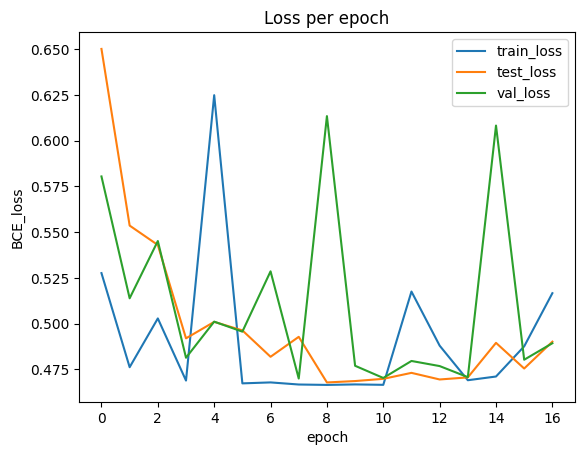

In [20]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_losses,label='train_loss')
plt.plot(test_losses,label='test_loss')
plt.plot(val_losses,label='val_loss')
plt.xlabel('epoch')
plt.ylabel('BCE_loss')
plt.title('Loss per epoch')
plt.legend()
plt.show()

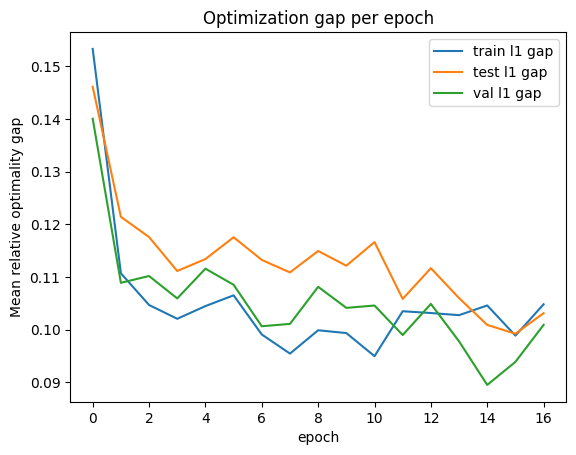

In [29]:
import matplotlib.pyplot as plt
# Plot the curves
plt.plot(train_l1_opt_gaps,label='train l1 gap')
plt.plot(test_l1_opt_gaps,label='test l1 gap')
plt.plot(val_l1_opt_gaps,label='val l1 gap')
plt.xlabel('epoch')
plt.ylabel('Mean relative optimality gap')
plt.title("Optimization gap per epoch")
plt.legend()
plt.show()

We see the loss having some fluctations. However, the gap decreases somewhat more smoothly. This indicates that our network is learing.

The last test would be to create instances with more nodes than those trained on. Here we create graphs of size 100 nodes. The gap is about 23%, not bad, but not the best either. Many things could be done differnetly, including generating way more training graphs.

In [30]:
from torch_geometric.utils import to_undirected,add_self_loops
from torch_geometric.data import Data
import itertools


new_data_list = []

num_datasets = 100

for num_nodes in [100]:
  node_coords, distance_matrices,solution_paths, solution_adjacencies, distances = generate_tsp_data(num_nodes = num_nodes,  num_datasets = num_datasets, check_correct=True)

  num_pos = num_nodes
  num_neg = num_nodes**2-num_nodes
  print(f'Number of solution edges {num_pos}')
  print(f'Number of false edges {num_neg} \n')


  weight_pos_class = (num_neg/num_pos)

  edge_index = torch.tensor(list(itertools.product(np.arange(num_nodes),np.arange(num_nodes))), dtype=torch.long).T.contiguous()
  for i in range(len(node_coords)):
      edge_attr = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)

      x = torch.tensor(node_coords[i]).float()
      y = torch.tensor(solution_adjacencies[i].flatten()).float().unsqueeze(1)


      data = Data(x=x, edge_index=edge_index, y= y, edge_attr=edge_attr)
      data.edge_weight = torch.tensor(((distance_matrices[i])).flatten()).float().unsqueeze(1)
      data.true_path = torch.Tensor(solution_paths[i])
      data.true_distance = torch.Tensor([distances[i]]).unsqueeze(1)
      data.num_nodes = num_nodes
      data.pos_class_weight = weight_pos_class
      new_data_list.append(data)



new_loader = DataLoader(new_data_list, batch_size=1, shuffle=False)



_, _, new_opt_gap = test(new_loader)

print(f'Mean relative opt. gap on new instances {new_opt_gap.item()}')



Number of solution edges 100
Number of false edges 9900 

Mean relative opt. gap on new instances 0.23467613756656647
